# <a id='toc1_'></a>[HCDN Elevation Bands Streamflow Distribution](#toc0_)
Author: Daniel Hogan

Created: August 22, 2023

This notebook will work to look at changes in the distribution of daily streamflow between the Millennium Drought and Baseline periods.

**Table of contents**<a id='toc0_'></a>    
- [HCDN Elevation Bands Streamflow Distribution](#toc1_)    
    - [Imports](#toc1_1_1_)    
- [Pull in Streamflow Data](#toc2_)    
    - [Calculate the day of water year flow at each site](#toc2_1_1_)    
    - [Group by mean elevation](#toc2_1_2_)    
    - [Calculate mean flow for each cluster](#toc2_1_3_)    
  - [Figure for Normal Daily Flow for each basin by elevation grouping](#toc2_2_)    
    - [Plot used in AGU Presentation to separate seasonal precipitation periods](#toc2_2_1_)    
- [Figure for Representative Basin and Difference between CDFs](#toc3_)    
    - [Figure 4: Comparing representative Basins](#toc3_1_1_)    
  - [Figure for Inter-Quartile Range Length](#toc3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Imports](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import datetime as dt
import scipy.stats as stats

# <a id='toc2_'></a>[Pull in Streamflow Data](#toc0_)

In [2]:
# Pull in hcdn_q_data from streamflowdata folder
hcdn_q_data = xr.open_dataset('../data/streamflowdata/selected_hcdn_basin_chars_and_daily_q.nc')

# create a function to calculate the day of water year for each date in the dataset
def day_of_water_year_func(date):
    if date.month >= 10:
        return (date - pd.to_datetime(str(date.year) + '-10-01')).days + 1
    else:
        return (date - pd.to_datetime(str(date.year - 1) + '-10-01')).days + 1

# apply the function to the date variable to create a new variable
day_of_water_year = [day_of_water_year_func(date) for date in pd.to_datetime(hcdn_q_data.datetime.values)]

# add the day of water year variable to the dataset
hcdn_q_data['day_of_water_year'] = xr.DataArray(day_of_water_year, dims=['datetime'], coords={'datetime': hcdn_q_data.datetime})
                                                

### <a id='toc2_1_1_'></a>[Calculate the day of water year flow at each site](#toc0_)

In [3]:
# calculate the day of water year flow at each site
water_year_mean_flow = hcdn_q_data.where((hcdn_q_data.datetime.dt.date>dt.date(1963,10,1)) & 
                                           ( hcdn_q_data.datetime.dt.date<dt.date(2022,10,1))).groupby('day_of_water_year').mean()['q_mm_day']


### <a id='toc2_1_2_'></a>[Group by mean elevation](#toc0_)

In [4]:
water_year_mean_flow = xr.merge([water_year_mean_flow,hcdn_q_data.elevation_category])


### <a id='toc2_1_3_'></a>[Calculate mean flow for each cluster](#toc0_)

In [5]:
# calculate the mean flow for each predicted cluster and day of water year
water_year_cluster_flow = water_year_mean_flow.groupby('elevation_category').mean()

## <a id='toc2_2_'></a>[Figure for Normal Daily Flow for each basin by elevation grouping](#toc0_)

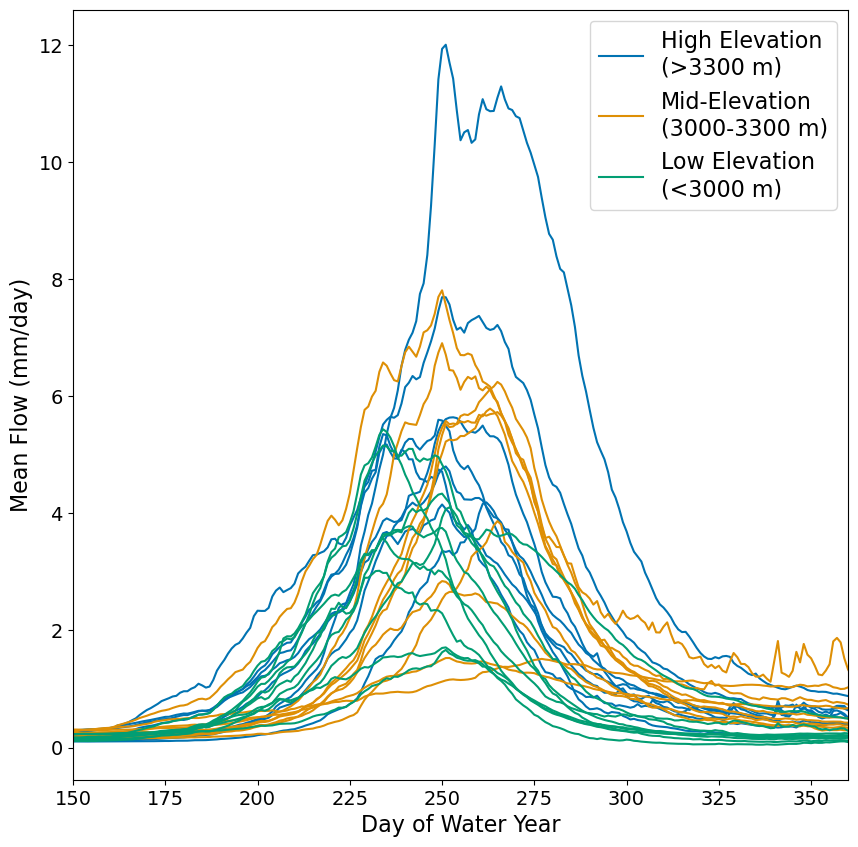

In [6]:
# create a figure and axis
fig, ax = plt.subplots(figsize=(10,10))
# plot each of the sites in water_year_mean_flow with each cluster having a different color
c = ['High Elevation\n(>3300 m)', 'Mid-Elevation\n(3000-3300 m)','Low Elevation\n(<3000 m)']
colors = sns.color_palette('colorblind', len(water_year_cluster_flow.elevation_category))
for j,cluster in enumerate(water_year_mean_flow.elevation_category.to_pandas().unique()):
    tmp_ds = water_year_mean_flow.where(water_year_mean_flow.elevation_category==cluster)
    for i,site in enumerate(tmp_ds.site_no.values):
        if tmp_ds.sel(site_no=site).q_mm_day.sum()<100 :
            if i == 0:
                ax.plot([],[], label=c[j], color=colors[j])
            continue
        elif i == 0:
            tmp_ds.sel(site_no=site).q_mm_day.plot(ax=ax, label=c[j], color=colors[j])
        else:
            tmp_ds.sel(site_no=site).q_mm_day.plot(ax=ax, color=colors[j])
# Set the x and y axis labels
ax.set_xlabel('Day of Water Year', size=16)
ax.set_ylabel('Mean Flow (mm/day)', size=16)
# Set the title
# ax.set_title('Mean Daily Flow by Day of Water Year for Basin Elevation Groups', size=18)
ax.set_title('')
# Add a legend for each of the colors
ax.legend(fontsize=16)
# set the xlim to 150-360
ax.set_xlim(150,360)
# set the x and y tick size to 14
ax.tick_params(labelsize=14)

### <a id='toc2_2_1_'></a>[Plot used in AGU Presentation to separate seasonal precipitation periods](#toc0_)

(14883.0, 15247.0)

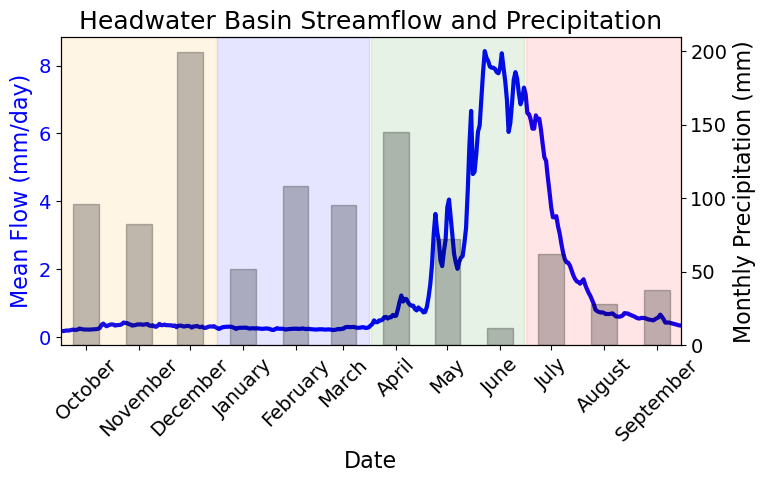

In [7]:
# create a figure to look at East River seasonal precipitation and streamflow for one year
monthly_ppt = xr.open_dataset('../data/precipdata/hcdn_monthly_prism_precip.nc')
east_river = '09112500'
water_year_slice = slice('2010-10-01', '2011-09-30')
# grab data for the east river site for the year specified
er_streamflow = hcdn_q_data.sel(datetime=water_year_slice).where(hcdn_q_data.site_no==east_river, drop=True).q_mm_day
# grab data from monthly ppt for the year and the east river
er_monthly_ppt = monthly_ppt.sel(month=water_year_slice).where(monthly_ppt.site_no==east_river, drop=True).ppt

# create a figure and axis
fig, ax = plt.subplots(figsize=(8,4))

# plot the precipitation as a bar plot
ax2 = ax.twinx()
ax2.bar(pd.to_datetime(er_monthly_ppt.month.values)+pd.to_timedelta('15 days'), er_monthly_ppt.values[0], label='Precipitation', color='k', width=15, alpha=0.25, ec='k')
# add y axis label
ax2.set_ylabel('Monthly Precipitation (mm)', size=16)
ax2.tick_params(axis='y', labelsize=14)

# plot the streamflow
er_streamflow.plot(ax=ax, label='Streamflow', color='b', lw=3)
# set the y axis labels
ax.set_ylabel('Mean Flow (mm/day)', size=16, color='b')
# change color of y axis labels and tick labels to blue
ax.tick_params(axis='y', labelcolor='blue', labelsize=14)

# set the x axis label
ax.set_xlabel('Date', size=16)
# change the x tick labels to be the month name spelled out starting in October
ax.set_xticks(pd.to_datetime(er_monthly_ppt.month.values)+pd.to_timedelta('15 days'))
ax.set_xticklabels(pd.to_datetime(er_monthly_ppt.month.values).strftime('%B'))
# set the x tick size
ax.tick_params(axis='x', labelsize=14, rotation=45)
# set the title
ax.set_title('Headwater Basin Streamflow and Precipitation', size=18)

# # add a vspan between November and April to show the cold season
# ax.axvspan(pd.to_datetime('2010-10-01'), pd.to_datetime('2011-03-31'), alpha=0.1, color='b', zorder=100)
# # add 2 vspans to show the warm season
# ax.axvspan(pd.to_datetime('2011-04-01'), pd.to_datetime('2011-09-30'), alpha=0.1, color='r', zorder=100)

# add a vspan from October through december for fall
ax.axvspan(pd.to_datetime('2010-10-01'), pd.to_datetime('2010-12-31'), alpha=0.1, color='orange', zorder=100)
# add a vspan from January through March for winter
ax.axvspan(pd.to_datetime('2011-01-01'), pd.to_datetime('2011-03-31'), alpha=0.1, color='b', zorder=100)
# add a vspan from April through June for spring
ax.axvspan(pd.to_datetime('2011-04-01'), pd.to_datetime('2011-06-30'), alpha=0.1, color='g', zorder=100)
# add a vspan from July through September for summer
ax.axvspan(pd.to_datetime('2011-07-01'), pd.to_datetime('2011-09-30'), alpha=0.1, color='r', zorder=100)


# # set the xlim to the first and last day of the year
ax.set_xlim(pd.to_datetime('2010-10-01'), pd.to_datetime('2011-09-30'))


# <a id='toc3_'></a>[Figure for Representative Basin and Difference between CDFs](#toc0_)

In [8]:
water_year_mean_flow_pre_2000 = hcdn_q_data.where((hcdn_q_data.datetime.dt.date>dt.date(1963,10,1)) & 
                                           ( hcdn_q_data.datetime.dt.date<dt.date(1999,10,1))).groupby('day_of_water_year').mean()['q_mm_day']
water_year_mean_flow_post_2000 = hcdn_q_data.where((hcdn_q_data.datetime.dt.date>dt.date(1999,10,1)) & 
                                           ( hcdn_q_data.datetime.dt.date<dt.date(2022,10,1))).groupby('day_of_water_year').mean()['q_mm_day']

In [9]:
high_example_pre = water_year_mean_flow_pre_2000.sel(site_no='09035900') # South Fork of Williams Fork
high_name = 'South Fork of Williams Fork (Gage ID: 09035900)'
mid_example_pre = water_year_mean_flow_pre_2000.sel(site_no='09112500') # East River Basin
mid_name = 'East River Basin (Gage ID: 09112500)'
low_example_pre = water_year_mean_flow_pre_2000.sel(site_no='09166500') # Dolores River at Dolores, CO
low_name = 'Dolores River at Dolores, CO (Gage ID: 09166500)'

high_example_post = water_year_mean_flow_post_2000.sel(site_no='09035900') # South Fork of Williams Fork
mid_example_post = water_year_mean_flow_post_2000.sel(site_no='09112500') # East River Basin
low_example_post = water_year_mean_flow_post_2000.sel(site_no='09166500') # Dolores River at Dolores, CO

Text(0.5, 0.98, 'Daily Water Year Mean Flow')

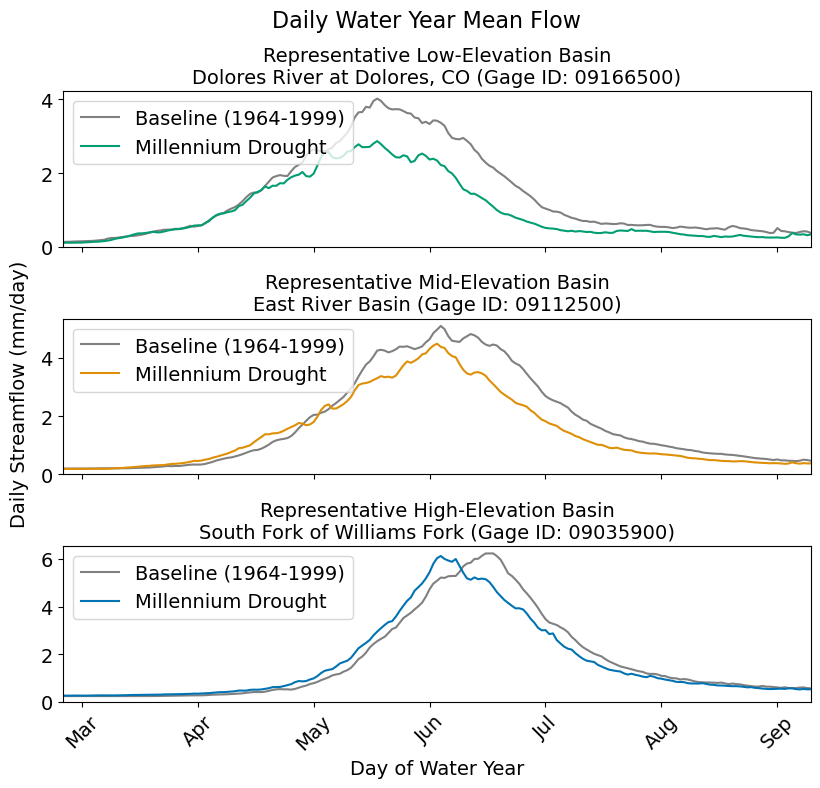

In [10]:
# create a figure and axis to plot the high example pre and post data
fig, axs = plt.subplots(3,1, figsize=(8,8), sharex=True, tight_layout=True)

ax = axs[2]
# Plot the high example pre and post data
high_example_pre.plot(ax=ax, label='Baseline (1964-1999)', color='gray')
high_example_post.plot(ax=ax, label='Millennium Drought', color=colors[0])

# set the x-axis to months
ax.set_xticks(np.arange(0,366,31))
ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']);
# rotate the x-axis labels 45 degrees
ax.tick_params(axis='x', rotation=45)
# set the y-axis label
ax.set_ylabel('')
ax.set_xlabel('Day of Water Year', size=14)
# set the title
ax.set_title(f'Representative High-Elevation Basin\n{high_name}', size=14)

ax = axs[1]
# Plot the high example pre and post data
mid_example_pre.plot(ax=ax, label='Baseline (1964-1999)', color='gray')
mid_example_post.plot(ax=ax, label='Millennium Drought', color=colors[1])
# set the x-axis to months
ax.set_xticks(np.arange(0,366,31))
ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']);
# rotate the x-axis labels 45 degrees
ax.tick_params(axis='x', rotation=45)
# set the y-axis label
ax.set_ylabel('')
ax.set_xlabel('')
# set the title
ax.set_title(f'Representative Mid-Elevation Basin\n{mid_name}', size=14)

ax = axs[0]
# Plot the high example pre and post data
low_example_pre.plot(ax=ax, label='Baseline (1964-1999)', color='gray')
# find the center of mass of high_example_pre
low_pre_com = np.abs(low_example_pre.cumsum()/low_example_pre.sum() - 0.50).idxmin().values
low_example_post.plot(ax=ax, label='Millennium Drought', color=colors[2])

# set the x-axis to months
ax.set_xticks(np.arange(0,366,31))
ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']);
# rotate the x-axis labels 45 degrees
ax.tick_params(axis='x', rotation=45)
# set the y-axis label
ax.set_ylabel('')
ax.set_xlabel('', size=14)
# set the title
ax.set_title(f'Representative Low-Elevation Basin\n{low_name}', size=14)

# For all subplots, set the xlim to 150-360
for ax in axs:
    ax.set_ylim(0,)
    ax.set_xlim(150,350)
    ax.legend(loc='upper left')
    # increase the font size of x and y ticks
    ax.tick_params(axis='both', which='major', labelsize=14)
    # increase the size of legend entries
    ax.legend(fontsize=14, loc='upper left')
    # increase the size of the x and y labels
# add a universal y-axis label
fig.text(-0.02, 0.5, 'Daily Streamflow (mm/day)', va='center', rotation='vertical', size=14)
fig.suptitle('Daily Water Year Mean Flow', size=16)

Text(0.5, 0.98, 'Center of Mass Change')

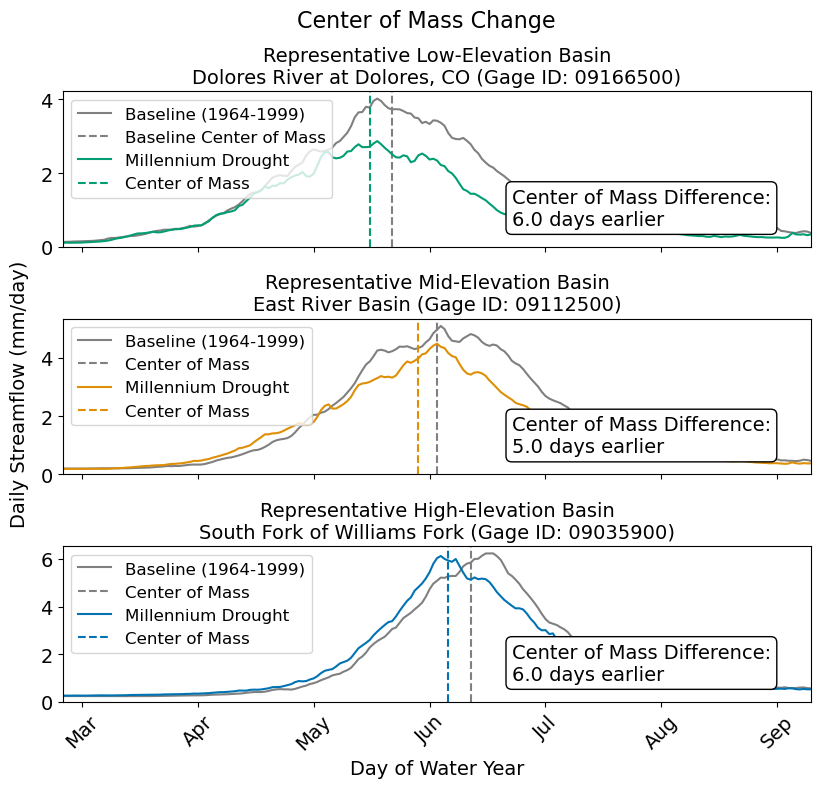

In [11]:
# create a figure and axis to plot the high example pre and post data
fig, axs = plt.subplots(3,1, figsize=(8,8), sharex=True, tight_layout=True)

ax = axs[2]
# Plot the high example pre and post data
high_example_pre.plot(ax=ax, label='Baseline (1964-1999)', color='grey')
# find the center of mass of high_example_pre
high_pre_com = np.abs(high_example_pre.cumsum()/high_example_pre.sum() - 0.50).idxmin().values
# plot a vertical line at the center of mass
ax.axvline(high_pre_com, color='grey', linestyle='--', label='Center of Mass')

high_example_post.plot(ax=ax, label='Millennium Drought', color=colors[0])
# find the center of mass of high_example_post
high_post_com = np.abs(high_example_post.cumsum()/high_example_post.sum() - 0.50).idxmin().values
# add a text box for the difference between the pre and post center of mass
ax.text(0.6, 0.25, f'Center of Mass Difference:\n{abs(high_post_com-high_pre_com)} days earlier', transform=ax.transAxes, fontsize=14,
        verticalalignment='center', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0))
# plot a vertical line at the center of mass
ax.axvline(high_post_com, color=colors[0], linestyle='--', label='Center of Mass')

# rotate the x-axis labels 45 degrees
ax.tick_params(axis='x', rotation=45)
# set the y-axis label
ax.set_ylabel('')
ax.set_xlabel('Day of Water Year', size=14)
# set the title
ax.set_title(f'Representative High-Elevation Basin\n{high_name}', size=14)

ax = axs[1]
# Plot the high example pre and post data
mid_example_pre.plot(ax=ax, label='Baseline (1964-1999)', color='grey')
# find the center of mass of high_example_pre
mid_pre_com = np.abs(mid_example_pre.cumsum()/mid_example_pre.sum() - 0.50).idxmin().values
# plot a vertical line at the center of mass
ax.axvline(mid_pre_com, color='grey', linestyle='--', label='Center of Mass')

mid_example_post.plot(ax=ax, label='Millennium Drought', color=colors[1])
# find the center of mass of high_example_post
mid_post_com = np.abs(mid_example_post.cumsum()/mid_example_post.sum() - 0.50).idxmin().values
# add a text box for the difference between the pre and post center of mass
ax.text(0.6, 0.25, f'Center of Mass Difference:\n{abs(mid_post_com-mid_pre_com)} days earlier', transform=ax.transAxes, fontsize=14,
        verticalalignment='center', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0))
# plot a vertical line at the center of mass
ax.axvline(mid_post_com, color=colors[1], linestyle='--', label='Center of Mass')

# rotate the x-axis labels 45 degrees
ax.tick_params(axis='x', rotation=45)
# set the y-axis label
ax.set_ylabel('')
ax.set_xlabel('')
# set the title
ax.set_title(f'Representative Mid-Elevation Basin\n{mid_name}', size=14)

ax = axs[0]
# Plot the high example pre and post data
low_example_pre.plot(ax=ax, label='Baseline (1964-1999)', color='grey')
# find the center of mass of high_example_pre
low_pre_com = np.abs(low_example_pre.cumsum()/low_example_pre.sum() - 0.50).idxmin().values
# plot a vertical line at the center of mass
ax.axvline(low_pre_com, color='grey', linestyle='--', label='Baseline Center of Mass')

low_example_post.plot(ax=ax, label='Millennium Drought', color=colors[2])
# find the center of mass of high_example_post
low_post_com = np.abs(low_example_post.cumsum()/low_example_post.sum() - 0.50).idxmin().values
# add a text box for the difference between the pre and post center of mass
ax.text(0.6, 0.25, f'Center of Mass Difference:\n{abs(low_post_com-low_pre_com)} days earlier', transform=ax.transAxes, fontsize=14,
        verticalalignment='center', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0))
# plot a vertical line at the center of mass
ax.axvline(low_post_com, color=colors[2], linestyle='--', label='Center of Mass')

# rotate the x-axis labels 45 degrees
ax.tick_params(axis='x', rotation=45)
# set the y-axis label
ax.set_ylabel('')
ax.set_xlabel('', size=14)
# set the title
ax.set_title(f'Representative Low-Elevation Basin\n{low_name}', size=14)

# For all subplots, set the xlim to 150-360
for ax in axs:
    # set the x-axis to months
    ax.set_xticks(np.arange(0,366,31))
    ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']);
    ax.set_ylim(0,)
    ax.set_xlim(150,350)
    ax.legend(loc='upper left',ncol=1,fontsize=12,)
    # increase the font size of x and y ticks
    ax.tick_params(axis='both', which='major', labelsize=14)
    # increase the size of the x and y labels
# add a universal y-axis label
fig.text(-0.02, 0.5, 'Daily Streamflow (mm/day)', va='center', rotation='vertical', size=14)
fig.suptitle('Center of Mass Change', size=16)


### <a id='toc3_1_1_'></a>[Figure 4: Comparing representative Basins](#toc0_)

This is part of figure 4 in the manuscript.

Pull in snow melt data. This comes from `dev_04_HCDN_snowmelt_dates.ipynb`

In [18]:
# pull in snowmelt stats from snowmelt_dates.ipynb
example_basin_sm_stats = pd.read_csv('../data/snowdata/example_basin_snow_stats.csv', index_col=0)
# add a 0 in from of the index values and convert to string
example_basin_sm_stats.index = ['0'+str(i) for i in example_basin_sm_stats.index]
# add a column titled elv_grp to example_basin_sm_stats with high, mid, and low values
example_basin_sm_stats['elv_grp'] = ['mid','low','high']

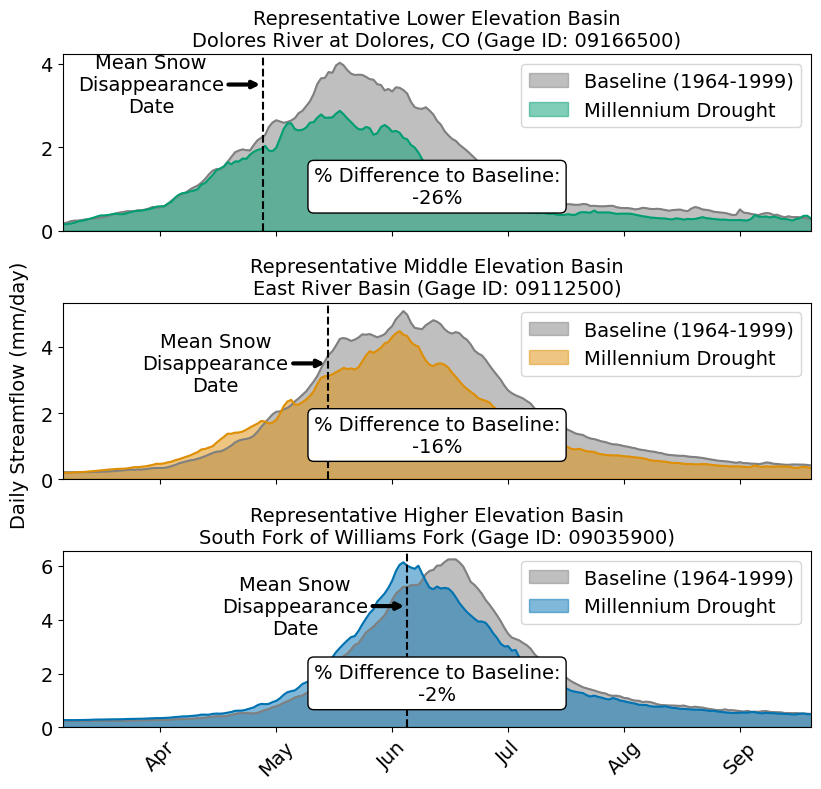

In [19]:
# create a figure and axis to plot the high example pre and post data
fig, axs = plt.subplots(3,1, figsize=(8,8), sharex=True, tight_layout=True)
# create a list of colors, one for each site
colors = sns.color_palette('colorblind', len(water_year_cluster_flow.elevation_category))

################## High Elevation Basin ##################
ax = axs[2]
# mean snowmelt dat
high_melt_date = example_basin_sm_stats[example_basin_sm_stats['elv_grp']=='high']['mean'].values+91
# Plot the high example pre and post data
high_example_pre.plot(ax=ax, color='grey')
# fill between high_example_pre 
ax.fill_between(high_example_pre.day_of_water_year, high_example_pre.values, color='grey', alpha=0.5,label='Baseline (1964-1999)')

high_example_post.plot(ax=ax, color=colors[0])
# fill between high_example_pre 
ax.fill_between(high_example_post.day_of_water_year, high_example_post.values, color=colors[0], alpha=0.5,label='Millennium Drought')

# add a vertical line at the mean of nfg_snow_melt_doy
ax.axvline(high_melt_date, color='black', linestyle='--')

# add text and an arrow to the mean of nfg_snow_melt_doy
ax.text(high_melt_date-30, 4.5, 
        'Mean Snow\nDisappearance\nDate', 
        fontsize=14, 
        verticalalignment='center', 
        horizontalalignment='center')
# add arrow pointing from the end of the text box to the axvline
ax.annotate('', xy=(high_melt_date, 4.5), xytext=(high_melt_date-10, 4.5),
            arrowprops=dict(arrowstyle='->', color='black', lw=3))

# Plot center of mass
# find the center of mass of high_example_pre
# high_pre_com = np.abs(high_example_pre.cumsum()/high_example_pre.sum() - 0.50).idxmin().values
# find the center of mass of high_example_post
# high_post_com = np.abs(high_example_post.cumsum()/high_example_post.sum() - 0.50).idxmin().values

# plot a vertical line at the center of mass
# ax.axvline(high_pre_com, color='grey', linestyle='--', label='Center of Mass')
# # add a text box for the difference between the pre and post center of mass
# ax.text(0.6,0.75, f'Center of Mass Difference:\n{abs(high_post_com-high_pre_com)} days earlier', transform=ax.transAxes, fontsize=14,
#         verticalalignment='center', 
#         bbox=dict(boxstyle='round', facecolor='white', alpha=1.0))
# plot a vertical line at the center of mass
# ax.axvline(high_post_com, color=colors[1], linestyle='--', label='Center of Mass')

# add a text box for the difference between the sums of the two periods
ax.text(0.5, 0.25,'% Difference to Baseline:\n{:.0f}%'.format(int(100*(high_example_post.sum() - high_example_pre.sum())/high_example_pre.sum())),
        horizontalalignment='center',fontsize=14,
        verticalalignment='center',
        transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0))

ax.set_xlabel('Day of Water Year', size=14)
# set the title
ax.set_title(f'Representative Higher Elevation Basin\n{high_name}', size=14)

################## Middle Elevation Basin ##################
ax = axs[1]
# mean snowmelt date
mid_melt_date = example_basin_sm_stats[example_basin_sm_stats['elv_grp']=='mid']['mean'].values+91
## Plot the high example pre and post data
mid_example_pre.plot(ax=ax, color='grey')
# fill between low_eexample_pre 
ax.fill_between(mid_example_pre.day_of_water_year, mid_example_pre.values, color='grey', alpha=0.5,label='Baseline (1964-1999)')

mid_example_post.plot(ax=ax, color=colors[1])
# fill between mid_example_pre 
ax.fill_between(mid_example_post.day_of_water_year, mid_example_post.values, color=colors[1], alpha=0.5,label='Millennium Drought')

# add a vertical line at the mean of nfg_snow_melt_doy
# ax.axvline(er_snow_melt_doy.dowy.mean(), color='black', linestyle='--')
ax.axvline(mid_melt_date, color='black', linestyle='--')
# add text and an arrow to the mean of nfg_snow_melt_doy
ax.text(mid_melt_date-30, 3.5, 'Mean Snow\nDisappearance\nDate', fontsize=14, verticalalignment='center', horizontalalignment='center')
# add arrow pointing from the end of the text box to the axvline
ax.annotate('', xy=(mid_melt_date, 3.5), xytext=(mid_melt_date-10, 3.5),
            arrowprops=dict(arrowstyle='->', color='black', lw=3))

# plot Center of mass
# find the center of mass of high_example_pre
# mid_pre_com = np.abs(mid_example_pre.cumsum()/mid_example_pre.sum() - 0.50).idxmin().values
# find the center of mass of high_example_post
# mid_post_com = np.abs(mid_example_post.cumsum()/mid_example_post.sum() - 0.50).idxmin().values

# plot a vertical line at the center of mass
# ax.axvline(mid_pre_com, color='grey', linestyle='--', label='Center of Mass')
# add a text box for the difference between the pre and post center of mass
# ax.text(0.6,0.75, f'Center of Mass Difference:\n{abs(mid_post_com-mid_pre_com)} days earlier', transform=ax.transAxes, fontsize=14,
#         verticalalignment='center', 
#         bbox=dict(boxstyle='round', facecolor='white', alpha=1.0))
# plot a vertical line at the center of mass
# ax.axvline(mid_post_com, color=colors[1], linestyle='--', label='Center of Mass')


# add a text box for the difference between the sums of the two periods
ax.text(0.5, 0.25, '% Difference to Baseline:\n{:.0f}%'.format(int(100*(mid_example_post.mean() - mid_example_pre.mean())/mid_example_pre.mean())),
        horizontalalignment='center',fontsize=14,
        verticalalignment='center',
        transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0))

# set the title
ax.set_title(f'Representative Middle Elevation Basin\n{mid_name}', size=14)

################## Lower Elevation Basin ##################
ax = axs[0]
# mean snowmelt date
low_melt_date = example_basin_sm_stats[example_basin_sm_stats['elv_grp']=='low']['mean'].values+91
# Plot the high example pre and post data
low_example_pre.plot(ax=ax, color='grey')
# fill between low_example_pre 
ax.fill_between(low_example_pre.day_of_water_year, low_example_pre.values, color='grey', alpha=0.5,label='Baseline (1964-1999)')

low_example_post.plot(ax=ax, color=colors[2])
# fill between low_example_post 
ax.fill_between(low_example_post.day_of_water_year, low_example_post.values, color=colors[2], alpha=0.5,label='Millennium Drought')

# add a vertical line at the mean of nfg_snow_melt_doy
# ax.axvline(nfg_snow_melt_doy.dowy..mean(), color='black', linestyle='--')

ax.axvline(low_melt_date, color='black', linestyle='--')
ax.text(low_melt_date-30, 3.5, 'Mean Snow\nDisappearance\nDate',fontsize=14, verticalalignment='center', horizontalalignment='center')
# add arrow pointing from the end of the text box to the axvline
ax.annotate('', xy=(low_melt_date, 3.5), xytext=(low_melt_date-10, 3.5),
            arrowprops=dict(arrowstyle='->', color='black', lw=3))


# Plot center of mass
# find the center of mass of high_example_pre
# low_pre_com = np.abs(low_example_pre.cumsum()/low_example_pre.sum() - 0.50).idxmin().values
# plot a vertical line at the center of mass
# ax.axvline(low_pre_com, color='grey', linestyle='--', label='Center of Mass')

# find the center of mass of high_example_post
# low_post_com = np.abs(low_example_post.cumsum()/low_example_post.sum() - 0.50).idxmin().values
# add a text box for the difference between the pre and post center of mass
# ax.text(0.6,0.75, f'Center of Mass Difference:\n{abs(low_post_com-low_pre_com)} days earlier', transform=ax.transAxes, fontsize=14,
#         verticalalignment='center', 
#         bbox=dict(boxstyle='round', facecolor='white', alpha=1.0))
# plot a vertical line at the center of mass
# ax.axvline(low_post_com, color=colors[1], linestyle='--', label='Center of Mass')

# add a text box for the difference between the sums of the two periods
ax.text(0.5, 0.25, '% Difference to Baseline:\n{:.0f}%'.format(int(100*(low_example_post.mean() - low_example_pre.mean())/low_example_pre.mean())),
        transform=ax.transAxes, fontsize=14,
        horizontalalignment='center',
        verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0))

# set the title
ax.set_title(f'Representative Lower Elevation Basin\n{low_name}', size=14)

# For all subplots, set the xlim to 150-360
for ax in axs:
    ax.legend(loc='upper left')
    # increase the font size of x and y ticks
    ax.tick_params(axis='both', which='major', labelsize=14)
    # rotate the x-axis labels 45 degrees
    ax.tick_params(axis='x', rotation=45)
    # set the x-axis to months
    ax.set_xticks(np.arange(0,366,31))
    ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']);
    # set the y-axis label
    ax.set_ylabel('')
    ax.set_xlabel('', size=14)
    # increase the size of legend entries
    ax.legend(fontsize=14, loc='upper right')
    # hide y axis ticks and labels
    ax.tick_params(axis='y', which='both', left=True, labelleft=True)   
    ax.set_ylim(0,)
    ax.set_xlim(160,360)
# add a universal y-axis label
fig.text(-0.02, 0.5, 'Daily Streamflow (mm/day)', va='center', rotation='vertical', size=14)
# add white facecolor
fig.patch.set_facecolor('white')
# fig.suptitle('Streamflow Volume Change', size=14)
fig.savefig('../figures/streamflow_change.svg', dpi=700, pad_inches=0.2, bbox_inches='tight')

Text(-0.02, 0.5, 'Percent of Annual Streamflow (%)')

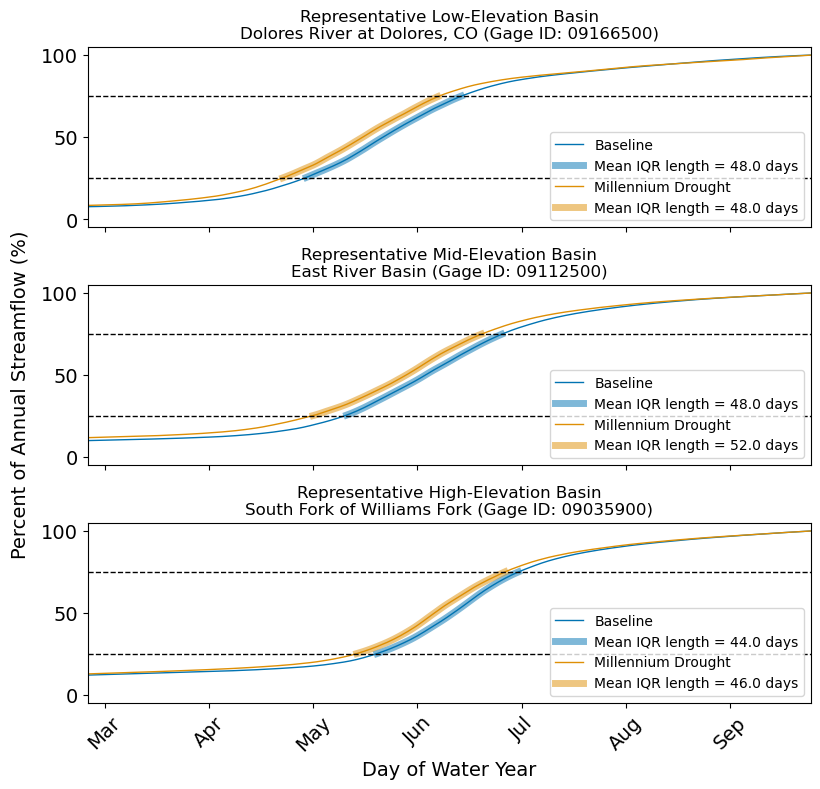

In [20]:
# create the figure
fig, axs = plt.subplots(3,1, figsize=(8,8), sharex=True, tight_layout=True)
# iterate through all sites and plot the above cumulative distribution
# create a list of colors, one for each site
colors = sns.color_palette('colorblind', len(water_year_cluster_flow.elevation_category)+1)
# create a list of mid-elevation, low-elevation, and high-elevation
elevations = ['Low', 'Mid', 'High']
names = [low_name, mid_name, high_name]
for i,(pre,post) in enumerate([(low_example_pre,low_example_post), (mid_example_pre,mid_example_post), (high_example_pre,high_example_post)]):
    tmp_pre_ds = (pre.cumsum(dim='day_of_water_year')/pre.sum(dim='day_of_water_year') * 100)
    tmp_post_ds = (post.cumsum(dim='day_of_water_year')/post.sum(dim='day_of_water_year') * 100)
    
    # find the day of water year for the 25th percentile
    iqr_25_index_pre = tmp_pre_ds.where(tmp_pre_ds <= 25, drop=True).day_of_water_year.values[-1]
    # find the day of water year for the 75th percentile
    iqr_75_index_pre = tmp_pre_ds.where(tmp_pre_ds >= 75, drop=True).day_of_water_year.values[0]

    # find the day of water year for the 25th percentile
    iqr_25_index_post = tmp_post_ds.where(tmp_post_ds <= 25, drop=True).day_of_water_year.values[-1]
    # find the day of water year for the 75th percentile
    iqr_75_index_post = tmp_post_ds.where(tmp_post_ds >= 75, drop=True).day_of_water_year.values[0]
    
    # create a filter for the inter quartile range
    iqr_pre_filter = (tmp_pre_ds >= 25) & (tmp_pre_ds <= 75)
    iqr_post_filter = (tmp_post_ds >= 25) & (tmp_post_ds <= 75) 
    
    # plot the Baseline and Millennium Drought cumulative distribution
    tmp_pre_ds.plot(label=f'Baseline', color=colors[0], lw=1, ax=axs[i], )
    # add a wider line for the interquartile range
    tmp_pre_ds.where(iqr_pre_filter, drop=True).plot(lw=5, alpha=0.5,color=colors[0], ax=axs[i], label=f'Mean IQR length = {iqr_75_index_pre - iqr_25_index_pre} days')
    
    tmp_post_ds.plot(label=f'Millennium Drought', lw=1, color=colors[1], ax=axs[i], )
    # add a wider line for the interquartile range
    tmp_post_ds.where(iqr_post_filter, drop=True).plot(lw=5, alpha=0.5, color=colors[1], ax=axs[i], label=f'Mean IQR length = {iqr_75_index_post - iqr_25_index_post} days')


    
    # make the x-axis a an axis of months
    axs[i].set_xticks(np.arange(0,366,31),['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']);
    # add horizontal line at 25% and 75% of annual streamflow
    axs[i].axhline(25, color='k', ls='--', lw=1)
    axs[i].axhline(75, color='k', ls='--', lw=1)
    # set y-axis limits
    axs[i].set_xlim(150,365)
    # rotate the x-axis labels 45 degrees
    axs[i].tick_params(axis='x', rotation=45)
    # make the y-axis a percentage
    axs[i].set_ylabel('')
    # set x-label
    if i == 2:
        axs[i].set_xlabel('Day of Water Year', size=14)
    else:
        axs[i].set_xlabel('')
    # set title to the predicted cluster
    axs[i].set_title(f'Representative {elevations[i].capitalize()}-Elevation Basin\n{names[i]}')
    # add legend
    axs[i].legend(loc='lower right')
    # increase font size of the xa and y-axis tick labels
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    
# create a shared y-axis label
fig.text(-0.02, 0.5, 'Percent of Annual Streamflow (%)', va='center', rotation='vertical', size=14)

## <a id='toc3_2_'></a>[Figure for Inter-Quartile Range Length](#toc0_)

This was used to look at changes in the timing of streamflow, but was not referenced in the analysis

(180.0, 300.0)

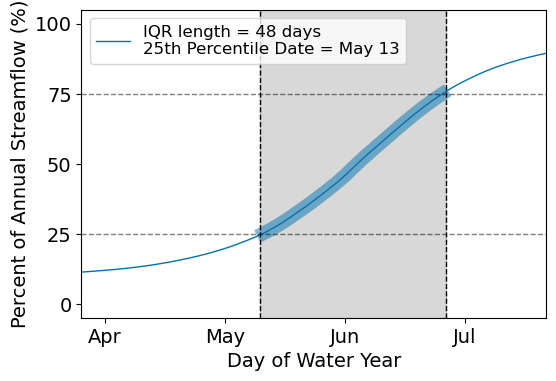

In [24]:
# create the figure
fig = plt.figure(figsize=(6,4))
# iterate through all sites and plot the above cumulative distribution
# create a list of colors, one for each site
colors = sns.color_palette('colorblind', len(water_year_cluster_flow.elevation_category))

for i,site in enumerate([2]):
    tmp_ds = (water_year_cluster_flow['q_mm_day'].cumsum(dim='day_of_water_year')/water_year_cluster_flow['q_mm_day'].sum(dim='day_of_water_year') * 100).isel(elevation_category=site)
    # find the day of water year for the 25th percentile
    iqr_25_index = tmp_ds.where(tmp_ds <= 25, drop=True).day_of_water_year.values[-1]
    # find the day of water year for the 75th percentile
    iqr_75_index = tmp_ds.where(tmp_ds >= 75, drop=True).day_of_water_year.values[0]
    
    # Initializing start date
    strt_date = dt.date(int(2020), 1, 1)
    
    # converting to date
    res_date = strt_date + dt.timedelta(days=int(iqr_25_index-92) - 1)
    res = res_date.strftime("%b %d")

    # plot the cumulative distribution
    # tmp_ds.plot(label=f'{str(water_year_cluster_flow.elevation_category.values[site]).upper()} - IQR length = {int(iqr_75_index - iqr_25_index)} days\n25th Percentile Date = {res}', color=colors[i], lw=1)
    tmp_ds.plot(label=f'IQR length = {int(iqr_75_index - iqr_25_index)} days\n25th Percentile Date = {res}', color=colors[i], lw=1)
    # create a filter for the inter quartile range
    iqr_filter = (tmp_ds >= 25) & (tmp_ds <= 75)
    # add a wider line for the interquartile range
    tmp_ds.where(iqr_filter, drop=True).plot(lw=10, alpha=0.5,color=colors[i],)
    # add horizontal line at 25th and 75th percentile
    plt.axhline(25, color='k', lw=1, ls='--', alpha=0.5)
    plt.axhline(75, color='k', lw=1, ls='--', alpha=0.5)
    
# make the x-axis a an axis of months
plt.xticks(np.arange(0,366,31),['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep'], size=14);
# add vspan between april and july
# plt.axvspan(31+30+31+31+29+31+2, 31+30+31+31+29+31+30+31+30+4, alpha=0.3, color='yellow')
plt.axvline(iqr_25_index, color='k', lw=1, ls='--', alpha=1)
plt.axvline(iqr_75_index, color='k', lw=1, ls='--', alpha=1)
plt.axvspan(iqr_25_index, iqr_75_index, alpha=0.3, color='grey',zorder=0)
# increase y-tick size
plt.yticks(size=14)
# make the y-axis a percentage
plt.ylabel('Percent of Annual Streamflow (%)', size=14)
# remove the x-label
plt.xlabel('Day of Water Year', size=14)
# make the title "Cumulative Distribution of Annual Streamflow"
# plt.title('Baseline Period (1964-1999)', size=14)
plt.title('')
plt.legend(fontsize=12)
# make yticks 0,25,50,75,100
plt.yticks([0,25,50,75,100])
plt.xlim(180,300)